## Install and Import Libraries

In [1]:
! pip install sentencepiece
! pip install transformers
! pip install datasets
! pip install sacremoses
! pip install accelerate
! pip install sacrebleu
! pip install bert_score
! pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.2 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 9.6 MB/s eta 0:00:00ta 0:00:01


In [2]:
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import sacrebleu

from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops
from transformers import (
    VisionEncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor,
    AutoModelForSeq2SeqLM, AutoTokenizer as AutoTokenizerLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
)
from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
from bert_score import score as bert_score

## Load Dataset

Sementara hanya menggunakan dataset GLI 

In [4]:
# Load data split radgenome
def load_json_files():
    with open('/kaggle/input/radgenome-caption/train.json', 'r') as f:
        train_data = json.load(f)
    with open('/kaggle/input/radgenome-caption/val.json', 'r') as f:
        val_data = json.load(f)
    with open('/kaggle/input/radgenome-caption/test.json', 'r') as f:
        test_data = json.load(f)
    return train_data, val_data, test_data

# Load caption dari dataset radgenome
def load_captions():
    caption_files = {
        # 'BraTS_MET': '/kaggle/input/radgenome-caption/BraTS_MET/modal_wise_finding.json',
        # 'BraTS_MEN': '/kaggle/input/radgenome-caption/BraTS_MEN/modal_wise_finding.json',
        'BraTS_GLI': '/kaggle/input/radgenome-caption/BraTS_GLI/modal_wise_finding.json'
    }
    captions = {}
    for dataset, file_path in caption_files.items():
        with open(file_path, 'r') as f:
            captions[dataset] = json.load(f)
    return captions

# Fungsi untuk dapatkan path image
def get_image_path(filename):
    if filename.startswith('BraTS-GLI'):
        prefix = filename.rsplit('-', 1)[0]
        return f"/kaggle/input/brats2023-part-1/{prefix}/{filename}.nii"
    elif filename.startswith('BraTS-MEN'):
        prefix = filename.rsplit('-', 1)[0]
        path1 = f"/kaggle/input/brats-men/BraTS-MEN-Train/{prefix}/{filename}.nii"
        path2 = f"/kaggle/input/meningits-part2/BraTS-MEN-Train2/{prefix}/{filename}.nii"
        return path1 if os.path.exists(path1) else path2
    elif filename.startswith('BraTS-MET'):
        prefix = filename.rsplit('-', 1)[0]
        train_path = f"/kaggle/input/brats2023/brats2023/brats2023-training/{prefix}/{filename}.nii"
        val_path = f"/kaggle/input/brats2023/brats2023/brats2023-validation/{prefix}/{filename}.nii"
        return train_path if os.path.exists(train_path) else val_path
    return None

# Ambil caption dan kategori (ini buat captioning nanti, segmentasi blm perlu)
def get_caption(filename, captions):
    if filename.startswith('BraTS-GLI'):
        return captions['BraTS_GLI'].get(filename, '')
    elif filename.startswith('BraTS-MEN'):
        return captions['BraTS_MEN'].get(filename, '')
    elif filename.startswith('BraTS-MET'):
        return captions['BraTS_MET'].get(filename, '')
    return ''

def get_category(filename):
    if filename.startswith('BraTS-GLI'):
        return 'GLI'
    elif filename.startswith('BraTS-MEN'):
        return 'MEN'
    elif filename.startswith('BraTS-MET'):
        return 'MET'
    return 'Unknown'

# Dapatkan path segmentasi dari image path
def get_segmentation_path(row):
    image_path = row['image_path']
    category = row['category']
    if image_path is None:
        return None
    if category in ['GLI', 'MEN', 'MET']:
        seg_filename = row['filename'].rsplit('-', 1)[0] + '-seg.nii'
        return os.path.join(os.path.dirname(image_path), seg_filename)
    return None

def process_dataset(filenames, captions):
    data = []
    for filename in filenames:
        # sementara hanya proses GLI
        if not filename.startswith('BraTS-GLI'):
            continue
            
        if filename.startswith('sub-strokecase'):
            continue
            
        if filename.startswith(('GE3T', 'Singapore', 'Utrecht')):
            continue  # skip WMH
            
        image_path = get_image_path(filename)
        if image_path is None or not os.path.exists(image_path):
            continue
        caption = get_caption(filename, captions)
        category = get_category(filename)
        data.append({
            'filename': filename,
            'image_path': image_path,
            'caption': caption,
            'category': category
        })
    df = pd.DataFrame(data)
    df['segmentation_path'] = df.apply(get_segmentation_path, axis=1)
    df = df[df['segmentation_path'].notna()]
    df = df[df['segmentation_path'].apply(lambda x: isinstance(x, str) and os.path.exists(x))].reset_index(drop=True)
    return df

# # Eksekusi all pipeline
# train_data, val_data, test_data = load_json_files()
# captions = load_captions()

# # Jika ingin menggunakan semua dataset (MEN dan MET)
# # all_filenames = train_data + val_data + test_data

# # Sementara gunakan dataset GLI terlebih dahulu
# all_filenames = [fn for fn in (train_data + val_data + test_data) if fn.startswith('BraTS-GLI')]
# df = process_dataset(all_filenames, captions)

In [5]:
# split train val test sesuai split dari radgenome di awal tadi
train_data, val_data, test_data = load_json_files()
captions = load_captions()

# process_dataset dipanggil untuk tiap split & gabungkan
train_df_src = process_dataset(train_data, captions)
val_df_src   = process_dataset(val_data, captions)
test_df_src  = process_dataset(test_data, captions)
combined = pd.concat([train_df_src, val_df_src, test_df_src], ignore_index=True)

# Base Extraction
combined['base'] = combined['filename'].apply(lambda x: str(x).rsplit("-",1)[0])
bases = combined.groupby('base').first().reset_index()

# stratified split di level base
train_frac = 0.60
temp_frac = 1.0 - train_frac
val_frac_of_temp = 0.5
RANDOM_STATE = 42

train_bases, temp_bases = train_test_split(
    bases,
    stratify=bases['category'],
    test_size=(1.0 - train_frac),
    random_state=RANDOM_STATE
)

val_bases, test_bases = train_test_split(
    temp_bases,
    stratify=temp_bases['category'],
    test_size=val_frac_of_temp,
    random_state=RANDOM_STATE
)

train_df = combined[combined['base'].isin(train_bases['base'])].drop(columns=['base']).reset_index(drop=True)
validation_df = combined[combined['base'].isin(val_bases['base'])].drop(columns=['base']).reset_index(drop=True)
test_df = combined[combined['base'].isin(test_bases['base'])].drop(columns=['base']).reset_index(drop=True)

# simpan hasil rebalanced
train_df.to_csv("train_dataset_rebalanced.csv", index=False)
validation_df.to_csv("val_dataset_rebalanced.csv", index=False)
test_df.to_csv("test_dataset_rebalanced.csv", index=False)

print("Train dataset:")
train_counts = train_df['category'].value_counts()
for category, count in train_counts.items():
    print(f"{category}: {count}")
print(f"Total: {len(train_df)}")

print("\nValidation dataset:")
val_counts = validation_df['category'].value_counts()
for category, count in val_counts.items():
    print(f"{category}: {count}")
print(f"Total: {len(validation_df)}")

print("\nTest dataset:")
test_counts = test_df['category'].value_counts()
for category, count in test_counts.items():
    print(f"{category}: {count}")
print(f"Total: {len(test_df)}")

Train dataset:
GLI: 280
Total: 280

Validation dataset:
GLI: 92
Total: 92

Test dataset:
GLI: 96
Total: 96


In [ ]:
# # perlu rebalance split data (karena split yang dibikin dari si radgenome ga fair, ada kategori yang samplenya kurang di bbrp split)

# np.random.seed(42)

# train_indices = train_df.index.tolist()
# sample_size = min(400, len(train_indices))
# random_indices = np.random.choice(train_indices, size=sample_size, replace=False)

# train_to_val = train_df.loc[random_indices]
# validation_df = pd.concat([validation_df, train_to_val], ignore_index=True)

# train_df = train_df.drop(random_indices)

# met_train_data = train_df[train_df['category'] == 'MET']
# met_sample_size = min(90, len(met_train_data))
# met_to_test_indices = np.random.choice(met_train_data.index, size=met_sample_size, replace=False)
# met_to_test = train_df.loc[met_to_test_indices]

# test_df = pd.concat([test_df, met_to_test], ignore_index=True)
# train_df = train_df.drop(met_to_test_indices)

# train_df = train_df.reset_index(drop=True)
# validation_df = validation_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# train_df.to_csv('train_dataset_rebalanced.csv', index=False)
# validation_df.to_csv('val_dataset_rebalanced.csv', index=False)
# test_df.to_csv('test_dataset_rebalanced.csv', index=False)

# print("Rebalanced Train dataset:")
# train_counts = train_df['category'].value_counts()
# for category, count in train_counts.items():
#     print(f"{category}: {count}")
# print(f"Total: {len(train_df)}")

# print("\nRebalanced Validation dataset:")
# val_counts = validation_df['category'].value_counts()
# for category, count in val_counts.items():
#     print(f"{category}: {count}")
# print(f"Total: {len(validation_df)}")

# print("\nRebalanced Test dataset:")
# test_counts = test_df['category'].value_counts()
# for category, count in test_counts.items():
#     print(f"{category}: {count}")
# print(f"Total: {len(test_df)}")

In [6]:
print(train_df.head())

                  filename                                         image_path  \
0  BraTS-GLI-00106-000-t1c  /kaggle/input/brats2023-part-1/BraTS-GLI-00106...   
1  BraTS-GLI-00106-000-t1n  /kaggle/input/brats2023-part-1/BraTS-GLI-00106...   
2  BraTS-GLI-00106-000-t2f  /kaggle/input/brats2023-part-1/BraTS-GLI-00106...   
3  BraTS-GLI-00106-000-t2w  /kaggle/input/brats2023-part-1/BraTS-GLI-00106...   
4  BraTS-GLI-00024-000-t1c  /kaggle/input/brats2023-part-1/BraTS-GLI-00024...   

                                             caption category  \
0  Post-contrast T1-weighted images reveal promin...      GLI   
1  There is an irregular lesion in the right fron...      GLI   
2  On FLAIR sequence, the lesion shows high signa...      GLI   
3  The lesion in the right frontal lobe displays ...      GLI   
4  The lesion demonstrates ring-enhancement post-...      GLI   

                                   segmentation_path  
0  /kaggle/input/brats2023-part-1/BraTS-GLI-00106...  
1  /kaggle/i

## Load Model Segmentasi & Generate Predicted Segmentation

In [7]:
# Load model segmentasi
SEG_MODEL_PATH = "/kaggle/input/3d-mri-brain-segmentation/keras/default/1/3D_MRI_Brain_tumor_segmentation.h5"
PRED_OUT_DIR = Path("/kaggle/working/predicted_masks")
PRED_OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_SIZE = 128  
TEST_RUN = False  # set False to run full dataset (but test True first)
TEST_N = 12

In [8]:
# dice loss
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num

    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
seg_model = tf.keras.models.load_model(
    SEG_MODEL_PATH,
    custom_objects={
        'dice_coef': dice_coef,
        'precision': precision,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice_coef_necrotic': dice_coef_necrotic,
        'dice_coef_edema': dice_coef_edema,
        'dice_coef_enhancing': dice_coef_enhancing
    },
    compile=False
)
print("Loaded segmentation model. GPU available:", bool(tf.config.list_physical_devices("GPU")))
print("Model input shape:", getattr(seg_model, "input_shape", None))

Loaded segmentation model. GPU available: True
Model input shape: (None, 128, 128, 2)


In [11]:
def preprocess_slice_from_vol(vol, idx, img_size=IMG_SIZE):
    sl = vol[:, :, idx].astype(np.float32)
    slr = cv2.resize(sl, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    maxv = slr.max()
    if maxv > 0:
        slr = slr / maxv
    return slr

def predict_full_volume_singlefile(image_path, seg_out_path, mode='duplicate'):
    vol_obj = nib.load(image_path)
    vol = vol_obj.get_fdata()
    affine = vol_obj.affine
    H, W, Z = vol.shape
    seg_resized = np.zeros((IMG_SIZE, IMG_SIZE, Z), dtype=np.uint8)

    for k in range(Z):
        s1 = preprocess_slice_from_vol(vol, k)
        if mode == 'duplicate':
            s2 = s1
        elif mode == 'zeros':
            s2 = np.zeros_like(s1)
        else:
            s2 = s1

        X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2), dtype=np.float32)
        X[0, :, :, 0] = s1
        X[0, :, :, 1] = s2

        pred = seg_model.predict(X, verbose=0)
        lbl = np.argmax(pred[0], axis=-1).astype(np.uint8)
        seg_resized[:, :, k] = lbl

    # resize back to original H,W using nearest neighbor (labels)
    seg_out = np.zeros((H, W, Z), dtype=np.uint8)
    for k in range(Z):
        seg_out[:, :, k] = cv2.resize(seg_resized[:, :, k], (W, H), interpolation=cv2.INTER_NEAREST)

    nib.save(nib.Nifti1Image(seg_out, affine=affine), str(seg_out_path))
    return True

def predict_full_volume_pair(image_path_A, image_path_B, seg_out_path):
    """
    image_path_A: FLAIR-like (t2f) path
    image_path_B: T1-CE path (must exist)
    Produces seg_out_path (canonical per-base).
    """
    # load volumes
    objA = nib.load(image_path_A); volA = objA.get_fdata()
    objB = nib.load(image_path_B); volB = objB.get_fdata()
    # ensure shapes match (they should in BraTS)
    if volA.shape != volB.shape:
        raise ValueError(f"Shape mismatch: {image_path_A} {volA.shape} vs {image_path_B} {volB.shape}")

    affine = objA.affine
    H, W, Z = volA.shape
    seg_resized = np.zeros((IMG_SIZE, IMG_SIZE, Z), dtype=np.uint8)

    for k in range(Z):
        a = preprocess_slice_from_vol(volA, k)
        b = preprocess_slice_from_vol(volB, k)
        X = np.zeros((1, IMG_SIZE, IMG_SIZE, 2), dtype=np.float32)
        X[0, :, :, 0] = a
        X[0, :, :, 1] = b

        pred = seg_model.predict(X, verbose=0)
        lbl = np.argmax(pred[0], axis=-1).astype(np.uint8)
        seg_resized[:, :, k] = lbl

    seg_out = np.zeros((H, W, Z), dtype=np.uint8)
    for k in range(Z):
        seg_out[:, :, k] = cv2.resize(seg_resized[:, :, k], (W, H), interpolation=cv2.INTER_NEAREST)

    nib.save(nib.Nifti1Image(seg_out, affine=affine), str(seg_out_path))
    return True

def generate_predseg_per_row_and_update_df(df, out_dir=PRED_OUT_DIR):
    """
    For each base in df: if BOTH t2f (FLAIR-like) and t1c (T1-CE) exist,
    generate one canonical <base>-predseg.nii using predict_full_volume_pair(),
    then propagate that path to all rows (all modalities) of that base.

    If t1c missing for a base -> leave pred_seg_path empty for that base.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    pred_map = {}  # base -> pred_path (only for bases where pair exists)

    # choose iteration set for pass1: debug small set if TEST_RUN True
    rows_for_pass1 = list(df.head(TEST_N).itertuples(index=False)) if TEST_RUN else list(df.itertuples(index=False))

    # PASS 1: generate pair preds for bases that have both t2f and t1c
    for r in tqdm(rows_for_pass1, desc="Pass1: generate pair preds"):
        fname = str(getattr(r, 'filename'))
        base = fname.rsplit('-', 1)[0]
        if base in pred_map:
            continue

        # gather rows for this base from full df
        rows_base = df[df['filename'].str.startswith(base)]
        p_t2 = None
        p_t1c = None
        for _, rr in rows_base.iterrows():
            fn = str(rr['filename']).lower()
            p = rr['image_path']
            if 't2f' in fn or 'flair' in fn:
                p_t2 = p
            if 't1c' in fn or 't1ce' in fn:
                p_t1c = p

        # require both paths to exist on disk
        if not p_t2 or not p_t1c:
            # either no t2f or no t1c → skip this base
            continue
        if not Path(p_t2).exists() or not Path(p_t1c).exists():
            # missing file on disk → skip
            continue

        # canonical output name per base (no modality suffix)
        out_name = f"{base}-predseg.nii"
        out_path = out_dir / out_name

        if not out_path.exists():
            try:
                predict_full_volume_pair(p_t2, p_t1c, out_path)
            except Exception as e:
                print("pair predict failed for", base, p_t2, p_t1c, "error:", e)
                continue

        pred_map[base] = str(out_path)

    # PASS 2: propagate pred_map to all rows of df
    pred_paths = []
    for _, row in df.iterrows():
        base = str(row['filename']).rsplit('-', 1)[0]
        pred_paths.append(pred_map.get(base, ""))

    df['pred_seg_path'] = pred_paths
    return df

In [4]:
train_df = generate_predseg_per_row_and_update_df(train_df)
train_df.to_csv('train_dataset_rebalanced_with_predseg.csv', index=False)

val_df = generate_predseg_per_row_and_update_df(validation_df)
val_df.to_csv('val_dataset_rebalanced_with_predseg.csv', index=False)

test_df = generate_predseg_per_row_and_update_df(test_df)
test_df.to_csv('test_dataset_rebalanced_with_predseg.csv', index=False)

In [8]:
# Fungsi untuk mengganti path /kaggle/working ke path dataset yang sudah dibuat
PRED_INPUT_DIR = Path("/kaggle/input/hasil-segmentasi-2/results (2)/predicted_masks")

def update_predseg_paths_from_input(df, pred_input_dir=PRED_INPUT_DIR):
    """
    Untuk tiap base di df, cari file <base>-predseg.nii di pred_input_dir.
    Jika ada, set df['pred_seg_path'] = str(path). Jika tidak ada, set ke "" (kosong).
    Fungsi tidak membuat file baru, hanya update/overwrite kolom pred_seg_path.
    """
    pred_input_dir = Path(pred_input_dir)
    pred_map = {}

    # buat set base unik untuk efisiensi
    bases = df['filename'].apply(lambda x: str(x).rsplit('-', 1)[0]).unique()

    for base in tqdm(bases, desc="Mapping existing predicted masks"):
        candidate = pred_input_dir / f"{base}-predseg.nii"
        if candidate.exists():
            pred_map[base] = str(candidate)
        else:
            # kalau tidak ada, kosongkan / atau bisa biarkan nilai lama
            pred_map[base] = ""

    # terapkan ke semua baris (tidak menambah kolom baru, langsung menimpa/isi kolom `pred_seg_path`)
    df['pred_seg_path'] = df['filename'].apply(lambda fn: pred_map.get(str(fn).rsplit('-', 1)[0], ""))

    return df

train_df = update_predseg_paths_from_input(train_df)
val_df   = update_predseg_paths_from_input(validation_df)
test_df  = update_predseg_paths_from_input(test_df)

# simpan kembali ke CSV — ini hanya menulis CSV, bukan membuat predseg baru
train_df.to_csv('train_dataset_rebalanced_with_predseg.csv', index=False)
val_df.to_csv('val_dataset_rebalanced_with_predseg.csv', index=False)
test_df.to_csv('test_dataset_rebalanced_with_predseg.csv', index=False)

Mapping existing predicted masks: 100%|██████████| 24/24 [00:00<00:00, 275.65it/s]


New random sample selected: BraTS-GLI-00293-000-t2f


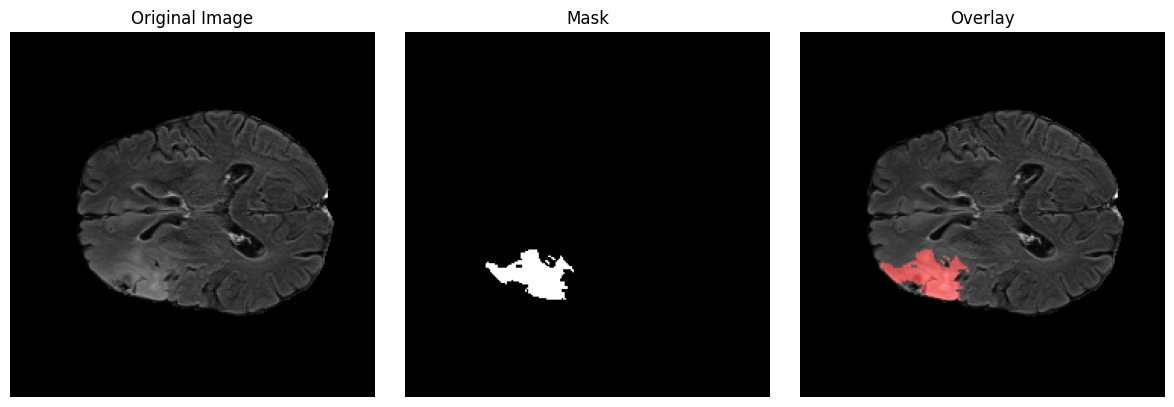

In [11]:
# Load csv
csv_path = "/kaggle/input/hasil-segmentasi-2/results (2)/train_dataset_rebalanced_with_predseg.csv"
train_df = pd.read_csv(csv_path)

# Fungsi untuk visualisasi
def pick_and_show_sample(df, slice_idx=None, force_new=False):
    global _SELECTED_SAMPLE
    if force_new or '_SELECTED_SAMPLE' not in globals():
        _SELECTED_SAMPLE = df.sample(1).iloc[0]
        print("New random sample selected:", _SELECTED_SAMPLE['filename'])
    else:
        print("Using cached sample:", _SELECTED_SAMPLE['filename'])
    row = _SELECTED_SAMPLE
    img = np.nan_to_num(nib.load(row['image_path']).get_fdata())
    mask = np.nan_to_num(nib.load(row['segmentation_path']).get_fdata())
    num_slices = img.shape[2]
    if slice_idx is None:
        slice_idx = num_slices // 2
    img_slice = img[:, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    if img_slice.max() > img_slice.min():
        norm_img = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
    else:
        norm_img = np.zeros_like(img_slice)
    img_rgb = np.stack([norm_img]*3, axis=-1)
    mask_bin = (mask_slice > 0).astype(float)
    overlay = img_rgb.copy()
    overlay[:, :, 0] += mask_bin * 0.5
    overlay = np.clip(overlay, 0, 1)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[1].imshow(mask_bin, cmap='gray')
    axes[1].set_title("Mask")
    axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

pick_and_show_sample(train_df, force_new=True)

New random sample selected: BraTS-GLI-00061-000-t1c


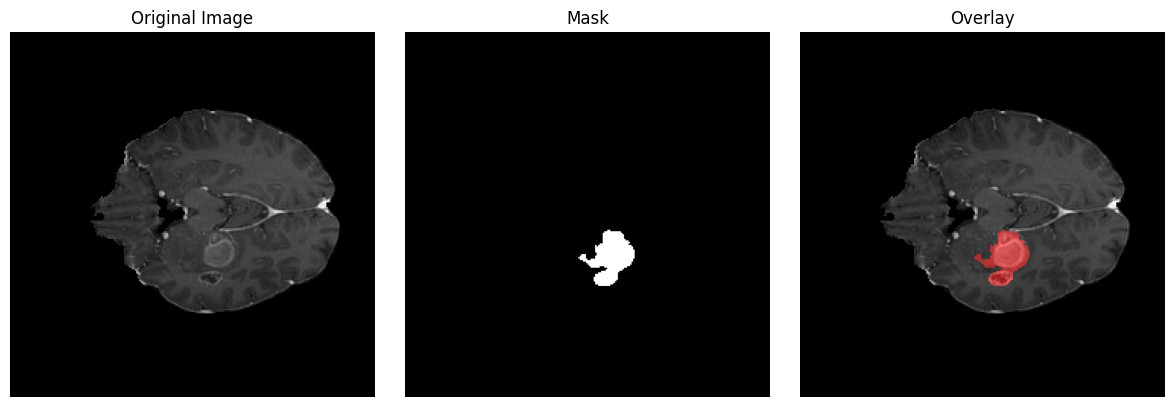

In [12]:
pick_and_show_sample(train_df, slice_idx=50, force_new=True) 

In [ ]:
pick_and_show_sample(train_df, slice_idx=65) 

In [ ]:
pick_and_show_sample(train_df, slice_idx=77) #(slice tengah biasanya di slice 77)

## Predicted Segmentation Policy

In [3]:
# Fungsi menghitung dice bin karena ada beberapa predicted segmentation yang jelek, jika jelek pakai Ground Truth segmentation
def dice_bin(a, b, eps=1e-6):
    a = (a > 0).astype(np.uint8)
    b = (b > 0).astype(np.uint8)
    inter = np.sum(a * b)
    return (2 * inter) / (np.sum(a) + np.sum(b) + eps)

def compute_dice_map(df):
    if 'base' not in df.columns:
        df['base'] = df['filename'].apply(lambda x: str(x).rsplit('-', 1)[0])
    bases = sorted(df['base'].unique())
    dice_map = {}
    for base in tqdm(bases, desc="Compute dice per base"):
        rows = df[df['base']==base]
        pred = next((p for p in rows['pred_seg_path'].fillna("").tolist() if p), "")
        gt = next((g for g in rows['segmentation_path'].fillna("").tolist() if g), "")
        if pred and gt and Path(pred).exists() and Path(gt).exists():
            try:
                a = nib.load(pred).get_fdata().astype(np.uint8)
                b = nib.load(gt).get_fdata().astype(np.uint8)
                dice_map[base] = float(dice_bin(a,b)) if a.shape==b.shape else np.nan
            except Exception:
                dice_map[base] = np.nan
        else:
            dice_map[base] = np.nan
    return dice_map

def apply_pred_vs_gt_policy(df, threshold=0.6, show_summary=True):
    """
    Update df['pred_seg_path'] in-place according to policy:
      - compute dice per base when both pred & gt exist and shapes match
      - if dice < threshold -> use GT (segmentation_path) as pred_seg_path (if GT exists)
      - else keep pred (if exists)
      - if neither exists -> empty string

    Returns updated df (same object) and dice_map (dict base->dice or np.nan)
    """
    # ensure base column exists or compute it
    if 'base' not in df.columns:
        df['base'] = df['filename'].apply(lambda x: str(x).rsplit('-', 1)[0])

    bases = sorted(df['base'].unique())
    dice_map = {}
    replaced_bases = []
    kept_bases = []
    missing_bases = []

    for base in tqdm(bases, desc="Computing dice per base"):
        rows_base = df[df['base'] == base]
        # pick first non-empty pred and gt for this base (if any)
        pred = ""
        gt = ""
        # prefer non-empty strings and paths that exist
        for p in rows_base['pred_seg_path'].fillna("").unique():
            if p:
                pred = str(p)
                break
        for g in rows_base['segmentation_path'].fillna("").unique():
            if g:
                gt = str(g)
                break

        # normalize to Path for existence check
        pred_path = Path(pred) if pred else None
        gt_path = Path(gt) if gt else None

        if pred_path and pred_path.exists() and gt_path and gt_path.exists():
            try:
                a = nib.load(str(pred_path)).get_fdata()
                b = nib.load(str(gt_path)).get_fdata()
            except Exception as e:
                # unreadable file -> mark as nan
                dice_map[base] = np.nan
                missing_bases.append(base)
                continue

            if a.shape == b.shape:
                d = float(dice_bin(a, b))
                dice_map[base] = d
            else:
                dice_map[base] = np.nan
            # apply policy
            if not np.isnan(dice_map[base]) and dice_map[base] < threshold:
                # prefer GT if available
                df.loc[df['base'] == base, 'pred_seg_path'] = str(gt_path)
                replaced_bases.append(base)
            else:
                # dice >= threshold -> keep pred (no-op)
                kept_bases.append(base)
        else:
            # missing either pred or gt
            dice_map[base] = np.nan
            # If GT exists but pred missing -> set pred_seg_path to GT
            if gt_path and gt_path.exists():
                df.loc[df['base'] == base, 'pred_seg_path'] = str(gt_path)
                replaced_bases.append(base)
            elif pred_path and pred_path.exists():
                # only pred exists -> keep it
                kept_bases.append(base)
            else:
                # neither exists -> set empty
                df.loc[df['base'] == base, 'pred_seg_path'] = ""
                missing_bases.append(base)

    if show_summary:
        total = len(bases)
        print(f"Total bases evaluated: {total}")
        print(f"Kept pred (dice >= {threshold} or only pred exists): {len(kept_bases)}")
        print(f"Replaced by GT (dice < {threshold} or pred missing but GT exists): {len(replaced_bases)}")
        print(f"No mask available (neither pred nor GT): {len(missing_bases)}")
        # optional: some dice stats (exclude nan)
        dice_vals = [v for v in dice_map.values() if not np.isnan(v)]
        if len(dice_vals) > 0:
            print(f"Dice stats on computed bases: mean {np.mean(dice_vals):.3f}, median {np.median(dice_vals):.3f}, count {len(dice_vals)}")
        else:
            print("No valid dice values computed (no pairs with both files and matching shapes).")

    return df, dice_map
    
# Fungsi Policy untuk Menentukan Segmentation yang akan Digunakan
def apply_policy_overwrite_pred_with_gt(df, dice_map, threshold=0.6, verbose=True):
    if 'base' not in df.columns:
        df['base'] = df['filename'].apply(lambda x: str(x).rsplit('-',1)[0])
    for base, d in dice_map.items():
        rows_base = (df['base'] == base)
        if not np.isnan(d):
            if d < threshold:
                gt = df.loc[rows_base, 'segmentation_path'].fillna("").iloc[0] if any(df.loc[rows_base,'segmentation_path'].fillna("")!="") else ""
                if gt and Path(gt).exists():
                    df.loc[rows_base, 'pred_seg_path'] = gt
        else:
            # fallback: if pred missing but GT exists -> set pred to GT
            pred_exists = any(df.loc[rows_base,'pred_seg_path'].fillna("")!="")
            gt_exists = any(df.loc[rows_base,'segmentation_path'].fillna("")!="")
            if (not pred_exists) and gt_exists:
                gt = df.loc[rows_base, 'segmentation_path'].fillna("").iloc[0]
                if gt and Path(gt).exists():
                    df.loc[rows_base, 'pred_seg_path'] = gt
    if verbose:
        vals = [v for v in dice_map.values() if not np.isnan(v)]
        if vals:
            print(f"Dice computed for {len(vals)} bases (mean={np.mean(vals):.3f}, median={np.median(vals):.3f})")
    return df

In [12]:
# Penggunaan
train_df, train_dice_map = apply_pred_vs_gt_policy(train_df, threshold=0.6)
train_df.to_csv('train_dataset_rebalanced_with_predseg.csv', index=False)

# validation/test
validation_df, val_dice_map = apply_pred_vs_gt_policy(validation_df, threshold=0.6)
validation_df.to_csv('val_dataset_rebalanced_with_predseg.csv', index=False)

test_df, test_dice_map = apply_pred_vs_gt_policy(test_df, threshold=0.6)
test_df.to_csv('test_dataset_rebalanced_with_predseg.csv', index=False)


Computing dice per base: 100%|██████████| 70/70 [01:57<00:00,  1.68s/it]


Total bases evaluated: 70
Kept pred (dice >= 0.6 or only pred exists): 61
Replaced by GT (dice < 0.6 or pred missing but GT exists): 9
No mask available (neither pred nor GT): 0
Dice stats on computed bases: mean 0.761, median 0.786, count 70


Computing dice per base: 100%|██████████| 24/24 [00:32<00:00,  1.36s/it]

Total bases evaluated: 24
Kept pred (dice >= 0.6 or only pred exists): 19
Replaced by GT (dice < 0.6 or pred missing but GT exists): 5
No mask available (neither pred nor GT): 0
Dice stats on computed bases: mean 0.717, median 0.754, count 24


In [4]:
import pandas as pd
import os

# Tentukan base path ke folder hasil Anda
base_path = "/kaggle/input/hasil-segmentasi-2/"

# Definisikan nama file
train_file = "train_dataset_rebalanced_with_predseg (12).csv"
val_file = "val_dataset_rebalanced_with_predseg (2).csv"
test_file = "test_dataset_rebalanced_with_predseg (3).csv"

# Load dataset dari file CSV

train_df = pd.read_csv(os.path.join(base_path, train_file))
validation_df = pd.read_csv(os.path.join(base_path, val_file))
test_df = pd.read_csv(os.path.join(base_path, test_file))
    
print("Berhasil me-load train_df, validation_df, dan test_df dari file CSV.")
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validasi: {len(validation_df)}")
print(f"Jumlah data test: {len(test_df)}")

Berhasil me-load train_df, validation_df, dan test_df dari file CSV.
Jumlah data train: 280
Jumlah data validasi: 92
Jumlah data test: 96


In [5]:
train_df.head()

,filename,image_path,caption,category,segmentation_path,pred_seg_path,base
0,BraTS-GLI-00106-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,Post-contrast T1-weighted images reveal promin...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00106-000
1,BraTS-GLI-00106-000-t1n,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,There is an irregular lesion in the right fron...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00106-000
2,BraTS-GLI-00106-000-t2f,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,"On FLAIR sequence, the lesion shows high signa...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00106-000
3,BraTS-GLI-00106-000-t2w,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,The lesion in the right frontal lobe displays ...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00106...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00106-000
4,BraTS-GLI-00024-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00024...,The lesion demonstrates ring-enhancement post-...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00024...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00024-000


In [6]:
validation_df.head()

,filename,image_path,caption,category,segmentation_path,pred_seg_path,base
0,BraTS-GLI-00686-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,Post-contrast T1-weighted images reveal signif...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00686-000
1,BraTS-GLI-00686-000-t1n,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,"In the right frontal, temporal, and insular lo...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00686-000
2,BraTS-GLI-00686-000-t2f,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,"On FLAIR images, the lesion in the right front...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00686-000
3,BraTS-GLI-00686-000-t2w,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,"The lesion in the right frontal, temporal, and...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00686...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00686-000
4,BraTS-GLI-00488-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00488...,"After contrast administration, the lesion in t...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00488...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00488-000


In [7]:
test_df.head()

,filename,image_path,caption,category,segmentation_path,pred_seg_path,base
0,BraTS-GLI-00291-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,The lesions exhibit uneven enhancement post co...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00291-000
1,BraTS-GLI-00291-000-t1n,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,Two lesions in the right parietal lobe show is...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00291-000
2,BraTS-GLI-00291-000-t2f,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,Two lesions in the right parietal lobe show mi...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00291-000
3,BraTS-GLI-00291-000-t2w,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,Two lesions in the right parietal lobe show hi...,GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00291...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00291-000
4,BraTS-GLI-00706-000-t1c,/kaggle/input/brats2023-part-1/BraTS-GLI-00706...,"After contrast administration, the lesion in t...",GLI,/kaggle/input/brats2023-part-1/BraTS-GLI-00706...,/kaggle/input/hasil-segmentasi-2/results (2)/p...,BraTS-GLI-00706-000


## Find Keywords

### Extract Keywords from Segmentation Mask

In [8]:
# Fungsi untuk ekstrak keyword di predicted segmentation
def extract_mask_keywords(mask_nii_path):
    seg_vol = nib.load(mask_nii_path).get_fdata().astype(int)
    vox_dims = nib.load(mask_nii_path).header.get_zooms()
    voxel_vol = np.prod(vox_dims)

    keywords = {}
    # total_tumor = 0 
    # centroids = {}
    solidity = {}
    eccentricity = {}

    for c in [1,2,3]:
        coords = np.argwhere(seg_vol == c)
        if len(coords)==0:
            # no voxels → skip
            continue
        # volumes
        cnt = coords.shape[0]
        vol_cm3 = cnt * voxel_vol / 1000
        if   vol_cm3 < 20: size="small"
        elif vol_cm3 <=50: size="moderate"
        else:              size="large"

        # centroid
        # cent = coords.mean(axis=0)
        # centroids[c] = cent
        # total_tumor += cnt

        # shape (pick largest region in each slice)
        sols, eccs = [], []
        for k in np.unique(coords[:,2]):
            mask2d = (seg_vol[:,:,k]==c).astype(int)
            if mask2d.sum()==0: continue
            rp = regionprops(label(mask2d))[0]
            sols.append(rp.solidity); eccs.append(rp.eccentricity)
        solidity[c]     = np.mean(sols)
        eccentricity[c] = np.mean(eccs)

        keywords[f"class_{c}_vol"] = round(vol_cm3,1)
        keywords[f"class_{c}_size"] = size

    # location of the main lesion (class 1) relative to mid‑planes
    # if 1 in centroids:
    #     mid = np.array(seg_vol.shape)/2
    #     hm = "left"  if centroids[1][0] < mid[0] else "right"
    #     ap = "anterior" if centroids[1][1] < mid[1] else "posterior"
    #     si = "inferior" if centroids[1][2] < mid[2] else "superior"
    #     keywords["location"] = f"{hm} {ap} {si}"

    # shape buckets
    for c in [1,2,3]:
        sol = solidity.get(c, 0)
        ecc = eccentricity.get(c, 0)
        keywords[f"class_{c}_shape"] = "compact" if sol>=0.8 else "irregular"
        keywords[f"class_{c}_form"]  = "rounded" if ecc<0.7 else "elongated"

    return keywords

In [9]:
import pprint
from pathlib import Path

# Tes fungsi 
df = train_df  

# contoh 10 base unik (kamu bisa ubah jumlahnya)
sample_bases = df['base'].unique().tolist()[:10]
print("Contoh bases (N={}):".format(len(sample_bases)))
print(sample_bases)

# pilih index (0..len(sample_bases)-1)
i = 8
base = sample_bases[i]
print("Memeriksa base:", base)

# ambil pred path (first non-empty)
rows = df[df['base']==base]
pred = next((p for p in rows['pred_seg_path'].fillna("").tolist() if p), "")
gt   = next((g for g in rows['segmentation_path'].fillna("").tolist() if g), "")

print("pred_seg_path:", pred)
print("segmentation_path (GT):", gt)

# cek keberadaan file
if pred and Path(pred).exists():
    print("Pred file exists — running extract_mask_keywords(pred)...")
    kws_pred = extract_mask_keywords(pred)
    pprint.pprint(kws_pred)
else:
    print("Pred file tidak ada atau kosong — skip extract pred.")

# opsional: juga cek GT
if gt and Path(gt).exists():
    print("\nGT file exists — running extract_mask_keywords(gt)...")
    kws_gt = extract_mask_keywords(gt)
    pprint.pprint(kws_gt)
else:
    print("GT file tidak ada atau kosong — skip extract GT.")


Contoh bases (N=10):
['BraTS-GLI-00106-000', 'BraTS-GLI-00024-000', 'BraTS-GLI-00604-000', 'BraTS-GLI-00734-001', 'BraTS-GLI-00322-000', 'BraTS-GLI-00598-000', 'BraTS-GLI-00397-000', 'BraTS-GLI-00443-000', 'BraTS-GLI-00652-000', 'BraTS-GLI-00478-000']
Memeriksa base: BraTS-GLI-00652-000
pred_seg_path: /kaggle/input/hasil-segmentasi-2/results (2)/predicted_masks/BraTS-GLI-00652-000-predseg.nii
segmentation_path (GT): /kaggle/input/brats2023-part-1/BraTS-GLI-00652-000/BraTS-GLI-00652-000-seg.nii
Pred file exists — running extract_mask_keywords(pred)...
{'class_1_form': 'elongated',
 'class_1_shape': 'irregular',
 'class_1_size': 'moderate',
 'class_1_vol': 32.4,
 'class_2_form': 'elongated',
 'class_2_shape': 'irregular',
 'class_2_size': 'large',
 'class_2_vol': 109.0,
 'class_3_form': 'elongated',
 'class_3_shape': 'irregular',
 'class_3_size': 'large',
 'class_3_vol': 85.6}

GT file exists — running extract_mask_keywords(gt)...
{'class_1_form': 'elongated',
 'class_1_shape': 'compact'

In [10]:
# Fungsi untuk membuat keyword map per base
def build_keywords_map_from_df(df, extractor_fn):
    bases = sorted(df['base'].unique())
    kw_map = {}
    for base in tqdm(bases, desc="Extract keywords per base"):
        rows = df[df['base']==base]
        pred = next((p for p in rows['pred_seg_path'].fillna("").tolist() if p), "")
        if pred and Path(pred).exists():
            try:
                kws = extractor_fn(pred)
                kw_map[base] = kws
            except Exception:
                kw_map[base] = {}
        else:
            kw_map[base] = {}
    return kw_map

In [11]:
subset_df = df[df['base'].isin(sample_bases)].copy()
kw_map_small = build_keywords_map_from_df(subset_df, extract_mask_keywords)

# tampilkan ringkasan
print("Total bases processed:", len(kw_map_small))
# contoh 5 base pertama dengan isi
import itertools
for base, kws in itertools.islice(kw_map_small.items(), 10):
    print("\nBase:", base)
    if kws:
        print("  keys:", list(kws.keys()))
        # tampilkan beberapa nilai penting kalau ada
        for k in ['class_1_vol','class_1_size','location','class_1_shape','class_1_form']:
            if k in kws:
                print(f"   {k}: {kws[k]}")
    else:
        print("  (no keywords found)")

Extract keywords per base: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

Total bases processed: 10

Base: BraTS-GLI-00024-000
  keys: ['class_1_vol', 'class_1_size', 'class_2_vol', 'class_2_size', 'class_3_vol', 'class_3_size', 'class_1_shape', 'class_1_form', 'class_2_shape', 'class_2_form', 'class_3_shape', 'class_3_form']
   class_1_vol: 20.9
   class_1_size: moderate
   class_1_shape: irregular
   class_1_form: elongated

Base: BraTS-GLI-00106-000
  keys: ['class_1_vol', 'class_1_size', 'class_2_vol', 'class_2_size', 'class_3_vol', 'class_3_size', 'class_1_shape', 'class_1_form', 'class_2_shape', 'class_2_form', 'class_3_shape', 'class_3_form']
   class_1_vol: 13.5
   class_1_size: small
   class_1_shape: irregular
   class_1_form: elongated

Base: BraTS-GLI-00322-000
  keys: ['class_1_vol', 'class_1_size', 'class_2_vol', 'class_2_size', 'class_3_vol', 'class_3_size', 'class_1_shape', 'class_1_form', 'class_2_shape', 'class_2_form', 'class_3_shape', 'class_3_form']
   class_1_vol: 10.9
   class_1_size: small
   class_1_shape: compact
   class_1_form: el

In [12]:
# # Fungsi untuk konversi keyword menjadi frasa natural singkat
def keywords_to_phrase(kws):
    if not kws:
        return ""
    parts = []
    if 'class_1_size' in kws and 'class_1_vol' in kws:
        parts.append(f"a {kws['class_1_size']} lesion (~{kws['class_1_vol']} cm³)")
    if 'location' in kws:
        parts.append(f"located in the {kws['location']}")
    if 'class_1_shape' in kws:
        parts.append(f"with {kws['class_1_shape']} morphology")
    if 'class_1_form' in kws:
        parts.append(f"and {kws['class_1_form']} form")
    phrase = ", ".join(parts)
    return phrase

In [13]:
# coba beberapa contoh phrase
for base in sample_bases[:10]:
    kws = kw_map_small.get(base, {}) or {}
    phrase = keywords_to_phrase(kws)
    print(f"\nBase: {base}")
    print(" kws:", kws)
    print(" phrase:", repr(phrase))


Base: BraTS-GLI-00106-000
 kws: {'class_1_vol': 13.5, 'class_1_size': 'small', 'class_2_vol': 75.9, 'class_2_size': 'large', 'class_3_vol': 146.0, 'class_3_size': 'large', 'class_1_shape': 'irregular', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'irregular', 'class_3_form': 'elongated'}
 phrase: 'a small lesion (~13.5 cm³), with irregular morphology, and elongated form'

Base: BraTS-GLI-00024-000
 kws: {'class_1_vol': 20.9, 'class_1_size': 'moderate', 'class_2_vol': 76.9, 'class_2_size': 'large', 'class_3_vol': 9.6, 'class_3_size': 'small', 'class_1_shape': 'irregular', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_form': 'elongated'}
 phrase: 'a moderate lesion (~20.9 cm³), with irregular morphology, and elongated form'

Base: BraTS-GLI-00604-000
 kws: {'class_1_vol': 36.5, 'class_1_size': 'moderate', 'class_2_vol': 146.0, 'class_2_size': 'large'

In [14]:
phrases = {b: keywords_to_phrase(kw_map_small.get(b, {}) or {}) for b in kw_map_small.keys()}
num_with_phrase = sum(1 for p in phrases.values() if p)
print(f"Bases with non-empty phrase: {num_with_phrase}/{len(phrases)}")

# distribusi ukuran kalau tersedia
sizes = []
for kw in kw_map_small.values():
    s = kw.get('class_1_size')
    if s:
        sizes.append(s)
from collections import Counter
print("Size distribution in sample:", Counter(sizes))

Bases with non-empty phrase: 10/10
Size distribution in sample: Counter({'moderate': 5, 'small': 5})


In [15]:
def inject_keywords_into_caption(original_caption, kw_phrase, method='append'):
    if not kw_phrase:
        return original_caption
    if method == 'integrate':
        import re
        sents = re.split(r'(?<=[.!?])\s+', original_caption.strip())
        if len(sents) > 1:
            sents[0] = sents[0].rstrip('.!?') + f", which is {kw_phrase}."
            return " ".join(sents)
        else:
            return original_caption.rstrip('.') + f". The segmentation suggests {kw_phrase}."
    else:
        return original_caption.rstrip('.') + f". The segmentation suggests {kw_phrase}."

In [16]:
base = sample_bases[0]
rows = df[df['base']==base].iloc[0]  # ambil satu row untuk caption dan preview
orig_caption = rows['caption']
kws = kw_map_small.get(base, {}) or {}
phrase = keywords_to_phrase(kws)
injected_preview = inject_keywords_into_caption(orig_caption, phrase, method='append')

print("Original caption:\n", orig_caption)
print("\nPhrase to inject:\n", phrase)
print("\nInjected preview:\n", injected_preview)


Original caption:
 Post-contrast T1-weighted images reveal prominent garland-like enhancement of the lesion, with unclear margins.

Phrase to inject:
 a small lesion (~13.5 cm³), with irregular morphology, and elongated form

Injected preview:
 Post-contrast T1-weighted images reveal prominent garland-like enhancement of the lesion, with unclear margins. The segmentation suggests a small lesion (~13.5 cm³), with irregular morphology, and elongated form.


In [17]:
def prepare_injected_caption_df(df, extractor_fn, threshold=0.6):
    dice_map = compute_dice_map(df)
    df = apply_policy_overwrite_pred_with_gt(df, dice_map, threshold=threshold, verbose=True)
    kw_map = build_keywords_map_from_df(df, extractor_fn)
    if 'base' not in df.columns:
        df['base'] = df['filename'].apply(lambda x: str(x).rsplit('-',1)[0])
    injected = []
    for _, row in df.iterrows():
        base = row['base']
        kws = kw_map.get(base, {}) or {}
        phrase = keywords_to_phrase(kws)
        newcap = inject_keywords_into_caption(str(row['caption']), phrase, method='append')
        injected.append(newcap)
    df['caption_injected'] = injected
    return df, dice_map, kw_map

## Create injected captions

In [18]:
# prepare
threshold = 0.6
df_prepared, dice_map, kw_map = prepare_injected_caption_df(train_df.copy(), extract_mask_keywords, threshold=threshold)
# agar mudah inspeksi, simpan juga df_prepared sebagai train_prepared
train_prepared = df_prepared
print("Done. Rows:", len(train_prepared))

Compute dice per base: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s]


Dice computed for 70 bases (mean=0.827, median=0.853)


Extract keywords per base: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]

Done. Rows: 280


In [19]:
import numpy as np
from collections import Counter

# dice summary
dice_vals = [v for v in dice_map.values() if not np.isnan(v)]
print("Bases total:", len(dice_map))
print("Dice computed (non-nan):", len(dice_vals))
if dice_vals:
    print("  mean: {:.3f}, median: {:.3f}, min: {:.3f}, max: {:.3f}".format(np.mean(dice_vals), np.median(dice_vals), np.min(dice_vals), np.max(dice_vals)))

# bases with dice < threshold
low_dice_bases = [b for b,v in dice_map.items() if (not np.isnan(v)) and (v < threshold)]
print("Bases with dice < {:.2f}: {}".format(threshold, len(low_dice_bases)))

# how many bases have no dice computed (nan)
nan_bases = [b for b,v in dice_map.items() if np.isnan(v)]
print("Bases with no dice (nan):", len(nan_bases))


Bases total: 70
Dice computed (non-nan): 70
  mean: 0.827, median: 0.853, min: 0.614, max: 1.000
Bases with dice < 0.60: 0
Bases with no dice (nan): 0


## Train Preparation & Finetuning

In [20]:
# load model + tokenizer + feature_extractor

import os
from pathlib import Path
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor, Trainer, TrainingArguments

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
os.environ["WANDB_DISABLED"] = "true" 

MODEL_DIR = "/kaggle/input/3dvit-biomedbert/tfjs/default/1/image caption model/model"
TOKENIZER_DIR = "/kaggle/input/3dvit-biomedbert/tfjs/default/1/image caption model/tokenizer"
FEATURE_EXTRACTOR_DIR = "/kaggle/input/3dvit-biomedbert/tfjs/default/1/image caption model/model"
T5_OUT_DIR = "./t5_edit_model"   
RESULTS_DIR = Path.cwd()
RESULTS_DIR.mkdir(exist_ok=True)

print("Loading model/tokenizer/feature_extractor")
vision_model = VisionEncoderDecoderModel.from_pretrained(MODEL_DIR).to(DEVICE)
vision_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)
feature_extractor = ViTFeatureExtractor.from_pretrained(FEATURE_EXTRACTOR_DIR)

# config / generation defaults
vision_model.config.decoder_start_token_id = vision_tokenizer.cls_token_id if vision_tokenizer.cls_token_id is not None else vision_tokenizer.bos_token_id
vision_model.config.pad_token_id = vision_tokenizer.pad_token_id
vision_model.config.eos_token_id = vision_tokenizer.eos_token_id
vision_model.config.max_length = 64
vision_model.config.num_beams = 4

print("Model loaded.")

Device: cuda
Loading model/tokenizer/feature_extractor


The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/embeddings']


Model loaded.


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [21]:
from PIL import Image
import numpy as np
import nibabel as nib

def nifti_to_pil_slice(nifti_path, slice_idx=None, normalize=True):
    """Load NIfTI, pick slice (center jika None), return PIL.Image (uint8 grayscale)."""
    img = nib.load(str(nifti_path)).get_fdata()
    # ensure 3D: if 4D, pick first volume
    if img.ndim == 4:
        img = img[..., 0]
    if img.ndim != 3:
        raise ValueError(f"Unsupported nii shape: {img.shape}")
    z = img.shape[2]
    if slice_idx is None:
        slice_idx = z // 2
    sl = np.array(img[:, :, slice_idx], dtype=float)
    if normalize:
        mn, mx = sl.min(), sl.max()
        if mx > mn:
            sl = (sl - mn) / (mx - mn)
        else:
            sl = sl * 0.0
    # convert to 0-255 uint8
    arr = (sl * 255).astype(np.uint8)
    pil = Image.fromarray(arr)
    # convert to RGB if feature_extractor expects 3-channel
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    return pil


In [22]:
def generate_captions_from_df_safe(df, vision_model, feature_extractor, vision_tokenizer,
                                   image_col='image_path', out_col='caption_generated',
                                   batch_size=8, slice_idx=None, device=None):
    if device is None:
        device = DEVICE
    vision_model = vision_model.to(device)
    vision_model.eval()
    generated = []
    paths = df[image_col].tolist()
    for i in tqdm(range(0, len(paths), batch_size), desc="Generating captions"):
        batch_paths = paths[i:i+batch_size]
        imgs = []
        for p in batch_paths:
            try:
                pil = nifti_to_pil_slice(p, slice_idx=slice_idx)
                imgs.append(pil)
            except Exception:
                imgs.append(None)
        imgs_input = [im for im in imgs if im is not None]
        if len(imgs_input) == 0:
            generated.extend([""]*len(imgs)); continue
        enc = feature_extractor(images=imgs_input, return_tensors="pt")
        pixel_values = enc['pixel_values'].to(device)
        with torch.no_grad():
            out = vision_model.generate(pixel_values=pixel_values,
                                        max_length=getattr(vision_model.config,'max_length',64),
                                        num_beams=getattr(vision_model.config,'num_beams',4))
        decoded = vision_tokenizer.batch_decode(out, skip_special_tokens=True)
        it = iter(decoded)
        for im in imgs:
            generated.append("" if im is None else next(it))
    df[out_col] = generated
    return df

In [23]:
train_df = generate_captions_from_df_safe(train_df, vision_model, feature_extractor, vision_tokenizer, 
                                          image_col='image_path', out_col='caption_generated', batch_size=4)

# quick peek
train_df[['filename','caption_generated']].head()

Generating captions:   0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Generating captions: 100%|██████████| 70/70 [03:06<00:00,  2.67s/it]


,filename,caption_generated
0,BraTS-GLI-00106-000-t1c,"after contrast administration, the lesion in t..."
1,BraTS-GLI-00106-000-t1n,in the right basal ganglia and insular - tempo...
2,BraTS-GLI-00106-000-t2f,"on flair imaging, the lesion in the right fron..."
3,BraTS-GLI-00106-000-t2w,the lesion in the right frontal lobe shows hig...
4,BraTS-GLI-00024-000-t1c,"after contrast administration, the lesion in t..."


In [24]:
validation_df = generate_captions_from_df_safe(validation_df, vision_model, feature_extractor, vision_tokenizer, 
                                          image_col='image_path', out_col='caption_generated', batch_size=4)

# quick peek
validation_df[['filename','caption_generated']].head()

Generating captions: 100%|██████████| 23/23 [01:01<00:00,  2.68s/it]


,filename,caption_generated
0,BraTS-GLI-00686-000-t1c,"after contrast administration, the lesion in t..."
1,BraTS-GLI-00686-000-t1n,in the right basal ganglia and insular - tempo...
2,BraTS-GLI-00686-000-t2f,"on flair sequence, the lesion in the right bas..."
3,BraTS-GLI-00686-000-t2w,the lesion in the right frontal lobe shows a m...
4,BraTS-GLI-00488-000-t1c,"after contrast administration, the lesion in t..."


In [25]:
train_kw_map = build_keywords_map_from_df(train_prepared, extract_mask_keywords)
print(train_kw_map)

Extract keywords per base: 100%|██████████| 70/70 [00:36<00:00,  1.91it/s]

{'BraTS-GLI-00006-000': {'class_1_vol': 52.1, 'class_1_size': 'large', 'class_2_vol': 71.8, 'class_2_size': 'large', 'class_3_vol': 30.3, 'class_3_size': 'moderate', 'class_1_shape': 'irregular', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'irregular', 'class_3_form': 'elongated'}, 'BraTS-GLI-00017-000': {'class_1_vol': 20.4, 'class_1_size': 'moderate', 'class_2_vol': 62.6, 'class_2_size': 'large', 'class_3_vol': 7.1, 'class_3_size': 'small', 'class_1_shape': 'irregular', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_form': 'elongated'}, 'BraTS-GLI-00021-000': {'class_1_vol': 0.9, 'class_1_size': 'small', 'class_2_vol': 81.6, 'class_2_size': 'large', 'class_3_vol': 6.8, 'class_3_size': 'small', 'class_1_shape': 'compact', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_for

In [26]:
# Prepare dataset for T5 fine-tuning (edit task)
def build_train_examples_from_df(df, kw_map):
    inputs, targets = [], []
    for _, row in df.iterrows():
        base = row['base']
        phrase = keywords_to_phrase(kw_map.get(base, {}) or {})
        src = f"edit: {row['caption_generated'].strip()} ||| findings: {phrase}"
        tgt = row['caption_injected'].strip()
        inputs.append(src)
        targets.append(tgt)
    return inputs, targets

In [28]:
# Fine-tune T5 (small) with HuggingFace Trainer
def fine_tune_t5(train_inputs, train_targets, val_inputs=None, val_targets=None,
                 model_name="t5-small", out_dir="./t5_edit_model", num_train_epochs=3,
                 per_device_train_batch_size=8, per_device_eval_batch_size=8):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.resize_token_embeddings(len(tokenizer))
    
    # tokenization
    def preprocess(examples):
        model_inputs = tokenizer(examples["input"], max_length=256, truncation=True, padding="max_length")
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(examples["target"], max_length=256, truncation=True, padding="max_length")
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    from datasets import Dataset, DatasetDict
    train_ds = Dataset.from_dict({"input": train_inputs, "target": train_targets})
    val_ds = Dataset.from_dict({"input": val_inputs, "target": val_targets}) if (val_inputs and val_targets) else None

    tokenized_train = train_ds.map(preprocess, batched=True, remove_columns=["input", "target"])
    tokenized_val = val_ds.map(preprocess, batched=True, remove_columns=["input", "target"]) if val_ds else None

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    training_args = Seq2SeqTrainingArguments(
        output_dir=out_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        evaluation_strategy="epoch" if tokenized_val else "no",
        save_strategy="epoch",
        predict_with_generate=True,
        logging_strategy="steps",
        logging_steps=50,
        fp16=torch.cuda.is_available()
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val if tokenized_val else None,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    trainer.train()
    trainer.save_model(out_dir)
    return out_dir, tokenizer, model

In [29]:
# Prepare injected captions (policy + extraction)
train_df, train_dice_map, train_kw_map = prepare_injected_caption_df(train_df, extract_mask_keywords, threshold=0.6)
validation_df, val_dice_map, val_kw_map = prepare_injected_caption_df(validation_df, extract_mask_keywords, threshold=0.6)

Compute dice per base: 100%|██████████| 70/70 [00:06<00:00, 10.76it/s]


Dice computed for 70 bases (mean=0.827, median=0.853)


Compute dice per base: 100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Dice computed for 23 bases (mean=0.818, median=0.814)


Extract keywords per base: 100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


In [30]:
# Build train examples for T5
train_inputs, train_targets = build_train_examples_from_df(train_df, train_kw_map)
val_inputs, val_targets = build_train_examples_from_df(validation_df, val_kw_map)

for i in range(10):
    print("SRC:", train_inputs[i])
    print("TGT:", train_targets[i])
    print("---")
    
# quick statistics
empty_src = sum(1 for s in train_inputs if not s.strip())
empty_tgt = sum(1 for t in train_targets if not t.strip())
print("Train pairs:", len(train_inputs), "empty src:", empty_src, "empty tgt:", empty_tgt)

SRC: edit: after contrast administration, the lesion in the right frontal lobe shows marked ring - like enhancement, with unclear, and measures approximately 12 * 12 * 73. is accompanied by a breakdown in size of the blood - like area of the right lateral ventricle, and is associated with no mention of the midline structures. ||| findings: a small lesion (~13.5 cm³), with irregular morphology, and elongated form
TGT: Post-contrast T1-weighted images reveal prominent garland-like enhancement of the lesion, with unclear margins. The segmentation suggests a small lesion (~13.5 cm³), with irregular morphology, and elongated form.
---
SRC: edit: in the right basal ganglia and insular - temporal lobe, there is an irregular lesion with isointense to low signal, indistinct boundaries, on t1 - weighted images, and surrounding brain parenchyma edema is present. the right lateral ventricle exhibiting isointensity, with no displacement of the midline structures, and ||| findings: a small lesion (~

In [24]:
# # generate baseline caption dari dataset
# from tqdm import tqdm
# import torch

# def generate_captions_from_df(df, model, feature_extractor, tokenizer,
#                               image_col='image_path',
#                               out_col='caption_generated',
#                               batch_size=8, slice_idx=None, device=DEVICE):
#     model.eval()
#     generated = []
#     paths = df[image_col].tolist()
#     B = batch_size
#     for i in tqdm(range(0, len(paths), B), desc="Generating captions"):
#         batch_paths = paths[i:i+B]
#         imgs = []
#         valid_idx = []
#         for j, p in enumerate(batch_paths):
#             try:
#                 pil = nifti_to_pil_slice(p, slice_idx=slice_idx)
#                 imgs.append(pil)
#                 valid_idx.append(i + j)
#             except Exception as e:
#                 # if can't load image, append None placeholder
#                 imgs.append(None)
#                 valid_idx.append(i + j)
#         # filter None
#         imgs_input = [im for im in imgs if im is not None]
#         if len(imgs_input) == 0:
#             # extend with empty strings for these indices
#             for _ in imgs:
#                 generated.append("")
#             continue

#         enc = feature_extractor(images=imgs_input, return_tensors="pt")
#         pixel_values = enc['pixel_values'].to(device)

#         # generate
#         with torch.no_grad():
#             out = model.generate(pixel_values=pixel_values,
#                                  max_length=model.config.max_length,
#                                  num_beams=getattr(model.config, "num_beams", 4))
#         texts = tokenizer.batch_decode(out, skip_special_tokens=True)
#         # map back: imgs_input corresponds to those with non-None only in order
#         it = iter(texts)
#         for im in imgs:
#             if im is None:
#                 generated.append("")
#             else:
#                 generated.append(next(it))
#     # attach to df
#     df[out_col] = generated
#     return df

# # Usage example (may be slow): generate for train_prepared or train_df
# train_df = generate_captions_from_df(train_prepared if 'train_prepared' in globals() else train_df,
#                                      model, feature_extractor, tokenizer,
#                                      image_col='image_path', out_col='caption_generated',
#                                      batch_size=8, slice_idx=None, device=DEVICE)
# # quick peek
# train_df[['filename','caption_generated']].head()

In [39]:
# def build_train_examples_from_df_with_source(df, kw_map, source_col='caption_generated'):
#     inputs, targets = [], []
#     for _, row in df.iterrows():
#         base = row['base']
#         phrase = keywords_to_phrase(kw_map.get(base, {}) or {})
#         source_caption = str(row.get(source_col, "")).strip()
#         # fallback to original caption if generated empty
#         if not source_caption:
#             source_caption = str(row.get('caption', "")).strip()
#         src = f"edit: {source_caption} ||| findings: {phrase}"
#         tgt = str(row.get('caption_injected', "")).strip()
#         inputs.append(src)
#         targets.append(tgt)
#     return inputs, targets

In [31]:
# Fine-tune T5 
out_dir, t5_tokenizer, t5_model = fine_tune_t5(
    train_inputs, train_targets, 
    val_inputs, val_targets,
    model_name="t5-small", 
    out_dir=T5_OUT_DIR, 
    num_train_epochs=2, 
    per_device_train_batch_size=4
)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/280 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/92 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.1

Epoch,Training Loss,Validation Loss
1,No log,1.078889
2,3.386400,1.000970


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [32]:
# === KODE DEBUGGING UNTUK VERIFIKASI DATA PELATIHAN T5 ===
print("--- Memeriksa Data Pelatihan (TRAIN) ---")
# Pastikan train_inputs dan train_targets ada dan tidak kosong
if 'train_inputs' in locals() and len(train_inputs) > 0:
    print(f"Total data pelatihan: {len(train_inputs)}")
    # Ambil 3 contoh acak
    for i in sorted(random.sample(range(len(train_inputs)), 3)):
        print(f"\n[Contoh Train {i}]")
        print(f"  SRC (Input T5): \n    {repr(train_inputs[i])}")
        print(f"  TGT (Target T5): \n    {repr(train_targets[i])}")
else:
    print("ERROR: 'train_inputs' tidak ditemukan atau kosong.")

print("\n--- Memeriksa Data Validasi (VALIDATION) ---")
# Periksa juga data validasi
if 'val_inputs' in locals() and len(val_inputs) > 0:
    print(f"Total data validasi: {len(val_inputs)}")
    # Ambil 1 contoh acak
    i = random.randint(0, len(val_inputs) - 1)
    print(f"\n[Contoh Val {i}]")
    print(f"  SRC (Input T5): \n    {repr(val_inputs[i])}")
    print(f"  TGT (Target T5): \n    {repr(val_targets[i])}")
else:
    print("ERROR: 'val_inputs' tidak ditemukan atau kosong.")
# ==========================================================

--- Memeriksa Data Pelatihan (TRAIN) ---
Total data pelatihan: 280

[Contoh Train 12]
  SRC (Input T5): 
    'edit: after contrast administration, the lesion in the left frontal lobe shows marked ring - like enhancement, suggesting the presence of a breakdown in the blood - brain on t1 - brain barrier, suggesting active lesion and possible breakdown. this finding, there is an active lesion is a significant garland - like area of the blood ||| findings: a moderate lesion (~30.1 cm³), with irregular morphology, and elongated form'
  TGT (Target T5): 
    "After contrast administration (T1C), the lesion in the left occipitotemporal lobe demonstrates significant garland-like enhancement, suggesting an active and possibly abnormal vascular process. The lesion's ill-defined nature is highlighted with contrast and measures approximately 73*102*94 mm. The segmentation suggests a moderate lesion (~30.1 cm³), with irregular morphology, and elongated form."

[Contoh Train 57]
  SRC (Input T5): 
 

## Inference & Evaluation

In [46]:
# 1) Ensure test_df prepared with policy + caption_injected: (same as training)
# test_df, test_dice_map, test_kw_map = prepare_injected_caption_df(test_df, extract_mask_keywords, threshold=0.6)

In [33]:
test_kw_map = build_keywords_map_from_df(test_df, extract_mask_keywords)
print(test_kw_map)

Extract keywords per base: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

{'BraTS-GLI-00012-000': {'class_1_vol': 125.1, 'class_1_size': 'large', 'class_2_vol': 115.3, 'class_2_size': 'large', 'class_3_vol': 22.4, 'class_3_size': 'moderate', 'class_1_shape': 'compact', 'class_1_form': 'elongated', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_form': 'elongated'}, 'BraTS-GLI-00032-001': {'class_1_vol': 7.6, 'class_1_size': 'small', 'class_2_vol': 82.2, 'class_2_size': 'large', 'class_3_vol': 49.4, 'class_3_size': 'moderate', 'class_1_shape': 'irregular', 'class_1_form': 'rounded', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_form': 'elongated'}, 'BraTS-GLI-00121-000': {'class_1_vol': 0.7, 'class_1_size': 'small', 'class_2_vol': 48.1, 'class_2_size': 'moderate', 'class_3_vol': 17.9, 'class_3_size': 'small', 'class_1_shape': 'compact', 'class_1_form': 'rounded', 'class_2_shape': 'irregular', 'class_2_form': 'elongated', 'class_3_shape': 'compact', 'class_3_form'

In [34]:
# 2) Generate baseline captions on test using explicit variables:
test_df = generate_captions_from_df_safe(test_df, vision_model, feature_extractor, vision_tokenizer,
                                             image_col='image_path', out_col='caption_generated', batch_size=4)

# quick peek
test_df[['filename','caption_generated']].head()

Generating captions: 100%|██████████| 24/24 [01:02<00:00,  2.61s/it]


,filename,caption_generated
0,BraTS-GLI-00291-000-t1c,post - contrast t1 - weighted imaging reveals ...
1,BraTS-GLI-00291-000-t1n,"in the right parietal lobe, there is a mass - ..."
2,BraTS-GLI-00291-000-t2f,the lesion in the right parietal lobe shows mi...
3,BraTS-GLI-00291-000-t2w,the lesion in the right parietal lobe appears ...
4,BraTS-GLI-00706-000-t1c,"after contrast administration, the lesion in t..."


In [35]:
# 3) Build T5 source strings
test_df['t5_src'] = test_df.apply(
    lambda r: f"edit: {r['caption_generated']} ||| findings: {keywords_to_phrase(test_kw_map.get(r['base'], {}))}",
    axis=1
)

t5_tokenizer = AutoTokenizerLM.from_pretrained(T5_OUT_DIR)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(T5_OUT_DIR).to(DEVICE)
t5_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [36]:
# run T5 inference
generated = []
batch_size = 8 # Bisa disesuaikan
for i in tqdm(range(0, len(test_df), batch_size), desc="T5 Inferencing"):
    batch = test_df['t5_src'].tolist()[i:i+batch_size]
    inputs = t5_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(DEVICE)
    
    with torch.no_grad():
        outs = t5_model.generate(**inputs, max_length=256, num_beams=4)
        
    dec = t5_tokenizer.batch_decode(outs, skip_special_tokens=True)
    generated.extend(dec)

test_df['caption_generated_injected'] = generated

T5 Inferencing: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]


In [37]:
def evaluate_corpus(hyps, refs):
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    P, R, F1 = bert_score(hyps, refs, lang='en', rescale_with_baseline=True)
    sbert = SentenceTransformer('all-mpnet-base-v2')
    emb_h = sbert.encode(hyps, convert_to_tensor=True)
    emb_r = sbert.encode(refs, convert_to_tensor=True)
    cosines = util.cos_sim(emb_h, emb_r).diag().cpu().numpy()
    return {"bleu": float(bleu.score), "bert_f1_mean": float(F1.mean().item()), "sbert_cosine_mean": float(cosines.mean())}

In [ ]:
# 4) Evaluate:
refs = test_df['caption'].fillna("").tolist()

print("\n--- 1. HASIL EVALUASI: Baseline (Tahap 1: vision_model) ---")
hyps_baseline = test_df['caption_generated'].tolist()
# Pastikan refs dan hyps memiliki panjang yang sama
if len(hyps_baseline) == len(refs):
    metrics_baseline = evaluate_corpus(hyps_baseline, refs)
    print(metrics_baseline)
else:
    print(f"Error: Panjang hipotesis ({len(hyps_baseline)}) tidak sama dengan referensi ({len(refs)})")


--- 1. HASIL EVALUASI: Baseline (Tahap 1: vision_model) ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
print("\n--- 2. HASIL EVALUASI: Model Akhir (Tahap 1 + Tahap 2: T5 Editor) ---")
hyps_final = test_df['caption_generated_injected'].tolist()
# Pastikan refs dan hyps memiliki panjang yang sama
if len(hyps_final) == len(refs):
    metrics_final = evaluate_corpus(hyps_final, refs)
    print(metrics_final)
else:
    print(f"Error: Panjang hipotesis ({len(hyps_final)}) tidak sama dengan referensi ({len(refs)})")

In [ ]:
print("\nContoh hasil akhir (head):")
print(test_df[['filename', 'caption', 'caption_generated', 't5_src', 'caption_generated_injected']].head())

In [ ]:
# # 4) Evaluate:
# refs = test_df['caption_injected'].fillna("").tolist()
# refs = [r if r else (test_df.loc[i,'caption'] if test_df.loc[i,'caption'] else "") for i,r in enumerate(refs)]
# metrics = evaluate_corpus(test_df['caption_generated_injected'].tolist(), refs)
# print(metrics)

In [ ]:
# 5) Save results:
test_df.to_csv(RESULTS_DIR / "test_with_generated_injected.csv", index=False)

In [ ]:
test_df.head()

In [ ]:
# # Evaluation utilities: BLEU + BERTScore + SBERT cosine
# def evaluate_corpus(hyps, refs):
#     # refs: list of references (strings)
#     bleu = sacrebleu.corpus_bleu(hyps, [refs])
#     P, R, F1 = bert_score(hyps, refs, lang='en', rescale_with_baseline=True)
#     # sbert
#     sbert = SentenceTransformer('all-mpnet-base-v2')
#     emb_h = sbert.encode(hyps, convert_to_tensor=True)
#     emb_r = sbert.encode(refs, convert_to_tensor=True)
#     cosines = util.cos_sim(emb_h, emb_r).diag().cpu().numpy()
#     return {
#         "bleu": float(bleu.score),
#         "bert_f1_mean": float(F1.mean().item()),
#         "sbert_cosine_mean": float(cosines.mean())
#     }